#### Librerias

In [41]:
import glob
import re
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer

#### Path de los datos

In [2]:
DATA = Path("../data/codigo_penal/text")

#### Inspeccionar data

In [3]:
file_list = sorted(glob.glob(f"{DATA}/*.txt"), key=lambda x: int(re.search(r"\d+", x).group()))
file_list

['../data/codigo_penal/text/cleaned_output_1.txt',
 '../data/codigo_penal/text/cleaned_output_2.txt',
 '../data/codigo_penal/text/cleaned_output_3.txt',
 '../data/codigo_penal/text/cleaned_output_4.txt',
 '../data/codigo_penal/text/cleaned_output_5.txt',
 '../data/codigo_penal/text/cleaned_output_6.txt',
 '../data/codigo_penal/text/cleaned_output_7.txt',
 '../data/codigo_penal/text/cleaned_output_8.txt',
 '../data/codigo_penal/text/cleaned_output_9.txt',
 '../data/codigo_penal/text/cleaned_output_10.txt',
 '../data/codigo_penal/text/cleaned_output_11.txt',
 '../data/codigo_penal/text/cleaned_output_12.txt',
 '../data/codigo_penal/text/cleaned_output_13.txt',
 '../data/codigo_penal/text/cleaned_output_14.txt',
 '../data/codigo_penal/text/cleaned_output_15.txt',
 '../data/codigo_penal/text/cleaned_output_16.txt',
 '../data/codigo_penal/text/cleaned_output_17.txt',
 '../data/codigo_penal/text/cleaned_output_18.txt',
 '../data/codigo_penal/text/cleaned_output_19.txt',
 '../data/codigo_pena

#### Cargar los datos

In [4]:
# Leer los archivos y guardarlos en una lista
docs = []
for file in file_list:
    with open(file, "r") as f:
        content = f.read()
        docs.append(content)
print(f"Numero de paginas del codigo penal: {len(docs)}")

Numero de paginas del codigo penal: 20


#### Preparar datos

In [5]:
# Se inspecciona el primer documento
print(docs[0][:5000])

LEY 599 DE 2000 
(julio 24) 
Diario Oficial No. 44.097 de 24 de julio de 2000 
<ADVERTENCIA: Ver el Resumen de Notas de Vigencia en relación con los criterios adoptados por el editor para calcular los aumentos de penas de que trata el Artículo 14 de la Ley 890 de 2004. 
Sobre el particular, el editor destaca que en la comunidad jurídica del país existen diferentes interpretaciones sobre el alcance de la siguiente frase del Artículo 14 de la Ley 890 de 2004: "Las penas previstas en los tipos penales contenidos en la Parte Especial del Código Penal ..."
La interpretación del editor se basa en la claridad del texto del Artículo 14 de la Ley 890 de 2004 y en las definiciones contenidas en los Artículos 35 y 43 del Código Penal (Ley 599 de 2000)>
<Según lo dispuesto por el Artículo 476 este Código entra a regir un (1) año después de su promulgación.>
EL CONGRESO DE COLOMBIA 
Por la cual se expide el Código Penal 
Resumen de Notas de Vigencia

Notas del Editor
- Destaca el editor lo dispuest

- Los datos tienen una division natural de 4 nuevas lineas (`\n`), por ende, se pueden separar en parrafos.

In [6]:
# Dividir los datos
split_by = "\n\n\n\n"
splitted_docs = [{"text": split_doc.strip()} for doc in docs for split_doc in doc.split(split_by)]
print(f"Numero de parrafos finales: {len(splitted_docs)}")

Numero de parrafos finales: 554


#### Construir el dataset
A la estructura que se quiere llegar es un `json` con dos elementos, el parrafo del articulo penal y el numero de tokens del modelo.

In [7]:
# Se crea el dataset
dataset = Dataset.from_list(splitted_docs)
dataset

Dataset({
    features: ['text'],
    num_rows: 554
})

In [8]:
# Ejemplo 1
dataset[50]

{'text': 'ARTÍCULO 49. LA PRIVACIÓN DEL DERECHO A LA TENENCIA Y PORTE DE ARMA. La imposición de la pena de privación del derecho a la tenencia y porte de arma inhabilitará al penado para el ejercicio de este derecho por el tiempo fijado en la sentencia.'}

In [9]:
# Ejemplo 2
dataset[100]

{'text': 'ARTÍCULO 100. COMISO. Los instrumentos y efectos con los que se haya cometido la conducta punible o que provengan de su ejecución, y que no tengan libre comercio, pasarán a poder de la Fiscalía General de la Nación o a la entidad que ésta designe, a menos que la ley disponga su destrucción. \nIgual medida se aplicará en los delitos dolosos, cuando los bienes, que tengan libre comercio y pertenezcan al responsable penalmente, sean utilizados para la realización de la conducta punible, o provengan de su ejecución. \nEn las conductas culposas, los vehículos automotores, naves o aeronaves, cualquier unidad montada sobre ruedas y los demás objetos que tengan libre comercio, se someterán a los experticios técnicos y se entregarán provisionalmente al propietario, legítimo tenedor salvo que se haya solicitado y decretado su embargo y secuestro. En tal caso, no procederá la entrega, hasta tanto no se tome decisión definitiva respecto de ellos. \nLa entrega será definitiva cuando se ga

In [10]:
# Se carga el tokenizador
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="lightblue/suzume-llama-3-8B-multilingual")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
# Ejemplo del tokenizador
example = "Hola como estas?"
print(f"Texto original: {example}")
print(tokenizer.tokenize(example))
print(tokenizer.encode(example))
print(f"Numero de tokens: {len(tokenizer.encode(example))}")

Texto original: Hola como estas?
['Hola', 'Ġcomo', 'Ġestas', '?']
[69112, 8112, 48591, 30]
Numero de tokens: 4


In [22]:
dataset = dataset.map(lambda x: {"tokens": len(tokenizer.tokenize(x["text"]))})

Map: 100%|██████████| 554/554 [00:00<00:00, 1358.49 examples/s]


In [24]:
# Ejemplo 1 tokenizado
dataset[50]

{'text': 'ARTÍCULO 49. LA PRIVACIÓN DEL DERECHO A LA TENENCIA Y PORTE DE ARMA. La imposición de la pena de privación del derecho a la tenencia y porte de arma inhabilitará al penado para el ejercicio de este derecho por el tiempo fijado en la sentencia.',
 'tokens': 69}

In [26]:
# Ejemplo 2 tokenizado
dataset[100]

{'text': 'ARTÍCULO 100. COMISO. Los instrumentos y efectos con los que se haya cometido la conducta punible o que provengan de su ejecución, y que no tengan libre comercio, pasarán a poder de la Fiscalía General de la Nación o a la entidad que ésta designe, a menos que la ley disponga su destrucción. \nIgual medida se aplicará en los delitos dolosos, cuando los bienes, que tengan libre comercio y pertenezcan al responsable penalmente, sean utilizados para la realización de la conducta punible, o provengan de su ejecución. \nEn las conductas culposas, los vehículos automotores, naves o aeronaves, cualquier unidad montada sobre ruedas y los demás objetos que tengan libre comercio, se someterán a los experticios técnicos y se entregarán provisionalmente al propietario, legítimo tenedor salvo que se haya solicitado y decretado su embargo y secuestro. En tal caso, no procederá la entrega, hasta tanto no se tome decisión definitiva respecto de ellos. \nLa entrega será definitiva cuando se ga

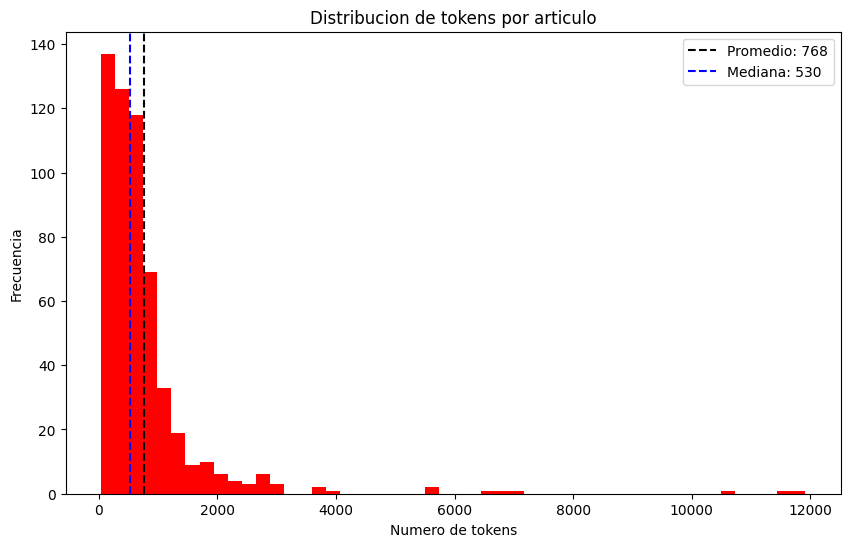

In [51]:
# Distribucion de tokens
plt.figure(figsize=(10, 6))
plt.hist(dataset["tokens"], bins=50, color="red")
plt.axvline(x=np.mean(dataset["tokens"]), color="black", linestyle="--", label=f"Promedio: {round(np.mean(dataset['tokens']))}")
plt.axvline(x=np.median(dataset["tokens"]), color="blue", linestyle="--", label=f"Mediana: {round(np.median(dataset['tokens']))}")
plt.title("Distribucion de tokens por articulo")
plt.xlabel("Numero de tokens")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

In [52]:
# Guardar el dataset
dataset.push_to_hub("codigo_penal")

Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/jjovalle99/codigo_penal/commit/f4aca2986e5e3f926470742c78d427774f426d54', commit_message='Upload dataset', commit_description='', oid='f4aca2986e5e3f926470742c78d427774f426d54', pr_url=None, pr_revision=None, pr_num=None)

![img](../assets/hf_dataset.png)